# Get the amplitudes
Michael Gully-Santiago  
June 2017

Get the amplitudes

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina' 
import warnings

### Read in the K2c02 data crossmatched with kplr

# Periods

In [2]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

We need functions:
1. Returns light curve given EPIC ID
2. Returns ranked peak periods given light curve
3. Determines whether lightcurve is single or double peaked.

Strategy for finding all the maxima: compute second derivative, look for all the concave up regions, compute maximum in each region, sort by maxima.

In [3]:
def light_curve_data():
    '''returns the light curve as numpy array, given EPIC ID'''

    file = '~/Desktop/beehive/c05/211900000/35518/' + \
                     'hlsp_k2sff_k2_lightcurve_211935518-c05_kepler_v1_llc-default-aper.txt'
    raw_lc = pd.read_csv(file, index_col=False, names=['time', 'flux'], skiprows=1)
    return raw_lc

In [4]:
def run_periodograms(light_curve, P_range=[0.1, 10], samples=10000):
    '''Returns periodograms for hardcoded subset of K2 Cycle 2 lightcurve'''
    x_full = light_curve.time.values
    y_full = light_curve.flux.values

    gi = y_full == y_full#(x_full > 2065) & (x_full < 2095)

    x, y = x_full[gi], y_full[gi]

    yerr = y*0.001
    
    periods = np.linspace(P_range[0], P_range[1], samples)

    omega = 2.00*np.pi/periods

    P_M = multiterm_periodogram(x, y, yerr, omega)
    P_LS = lomb_scargle(x, y, yerr, omega)
    return (periods, P_M, P_LS)

In [5]:
from scipy.signal import argrelmax

In [6]:
def top_N_periods(periods, lomb_scargle_power, n=5):
    '''Returns the top N Lomb-Scargle periods, given a vector of the periods and values'''
    
    # Get all the local maxima
    all_max_i = argrelmax(lomb_scargle_power)
    max_LS = lomb_scargle_power[all_max_i]
    max_periods = periods[all_max_i]
    
    # Sort by the Lomb-Scale power
    sort_i = np.argsort(max_LS)
    
    # Only keep the top N periods
    top_N_LS = max_LS[sort_i][::-1][0:n]
    top_N_pers = max_periods[sort_i][::-1][0:n]
    
    return top_N_pers, top_N_LS

In [7]:
def plot_LC_and_periodograms(lc, periods, P_M, P_LS):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.step(lc.time, lc.flux)
    #plt.xlim(2065, 2095)
    plt.subplot(122)
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

In [8]:
def plot_periodograms(periods, P_M, P_LS):
    plt.figure(figsize=(8,8))
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

In [9]:
lc = light_curve_data()

In [10]:
periods, P_M, P_LS = run_periodograms(lc, P_range=[1.1, 3.1], samples=10000)

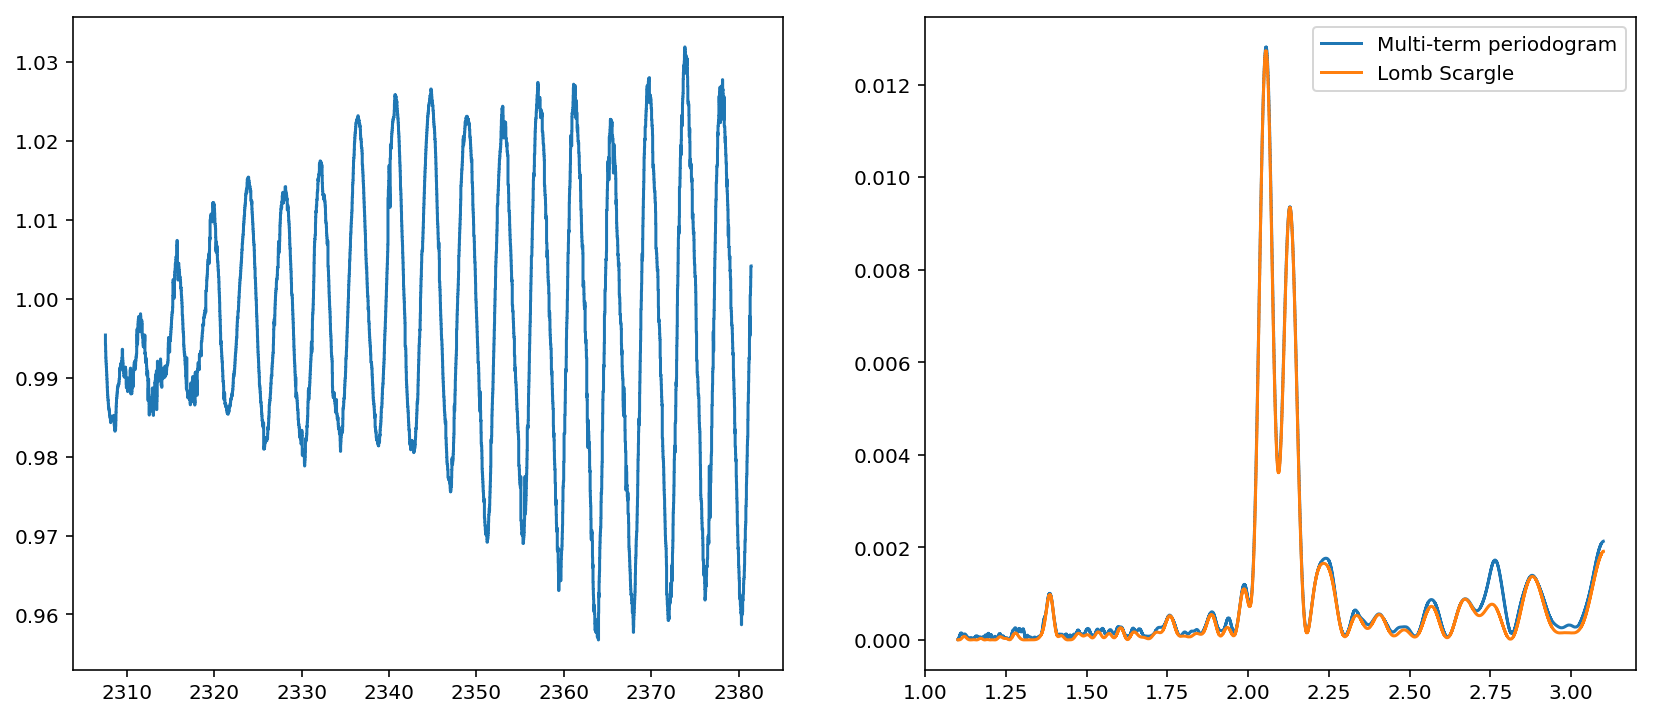

In [11]:
plot_LC_and_periodograms(lc, periods, P_M, P_LS)

In [12]:
v1, v2 = top_N_periods(periods, P_M)

In [13]:
v1

array([ 2.05549555,  2.12930293,  2.24111411,  2.76476648,  2.87977798])

In [14]:
v2

array([ 0.01281949,  0.00936209,  0.00176711,  0.00172808,  0.0013988 ])

## Loop it

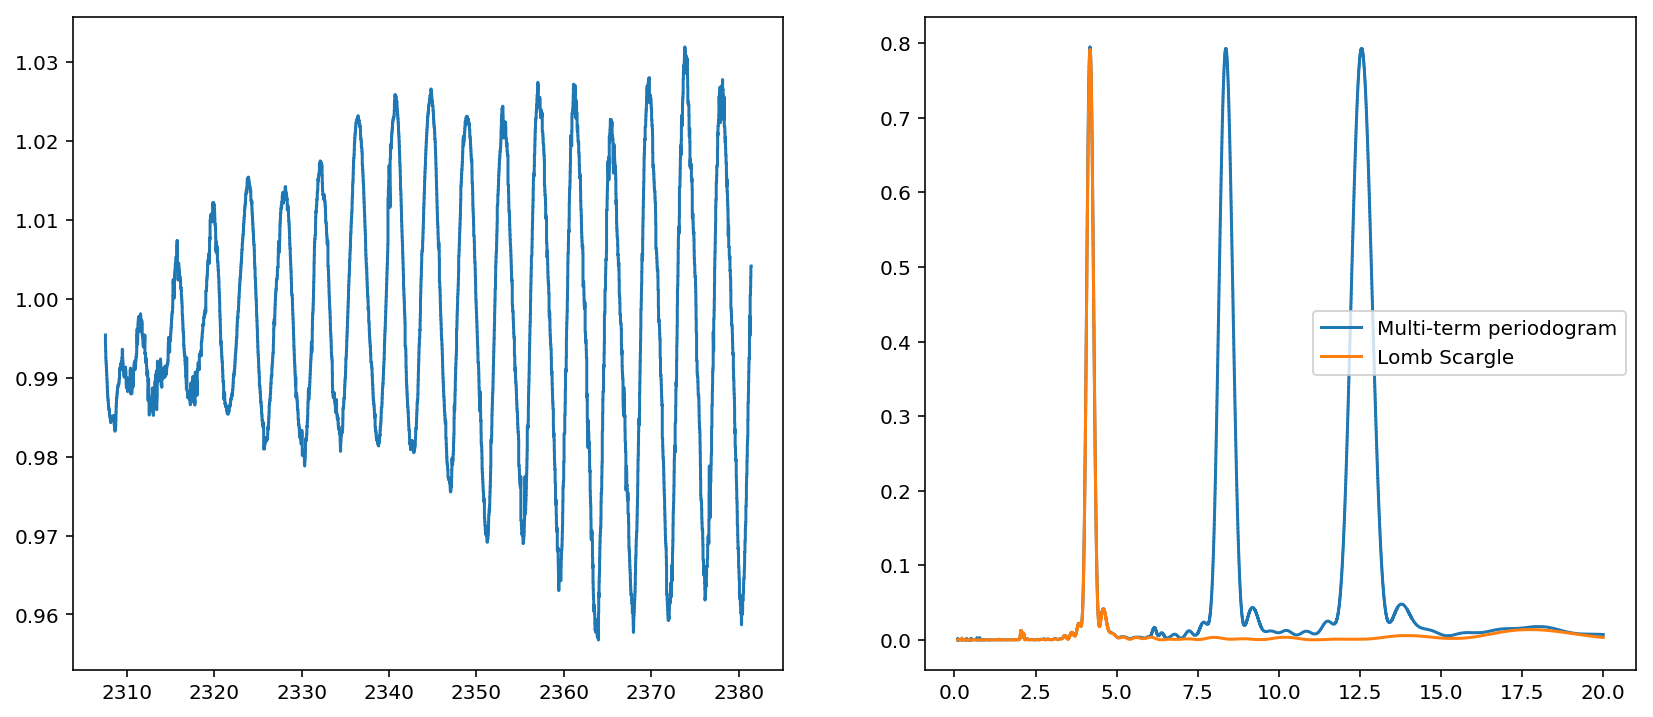

In [15]:
periods, P_M, P_LS = run_periodograms(lc, P_range=[0.1,20])
plot_LC_and_periodograms(lc, periods, P_M, P_LS)

In [16]:
P_coarse_fit = periods[np.argmax(P_LS)]

In [17]:
lc.columns

Index(['time', 'flux'], dtype='object')

In [18]:
x_full = lc.time.values
y_full = lc.flux.values

gi = x_full==x_full#(x_full > 2065) & (x_full < 2095)

x, y = x_full[gi], y_full[gi]

yerr = y*0.001

In [19]:
periods = np.linspace(P_coarse_fit*0.8, P_coarse_fit*1.2, 10000)

omega = 2.00*np.pi/periods

P_M = multiterm_periodogram(x, y, yerr, omega)
P_LS = lomb_scargle(x, y, yerr, omega)

In [20]:
P_fit = periods[np.argmax(P_LS)]

In [21]:
P_fit

4.1834699581569312

# Linear regression example

$y = c_0 + c_1 \cdot x + c_2 \cdot \sin{\frac{2\pi x}{P}} + c_3 \cdot \cos{\frac{2\pi x}{P}} $

We have four coefficients: $c_1, c_2, c_3, c_4$

In [22]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)

In [23]:
A = np.concatenate((np.expand_dims(cos_vector, 1),
                    np.expand_dims(sin_vector, 1),
                    np.vander(x, 1)), axis=1)

In [24]:
ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

In [25]:
yfit = np.matmul(mean_w, A.T)

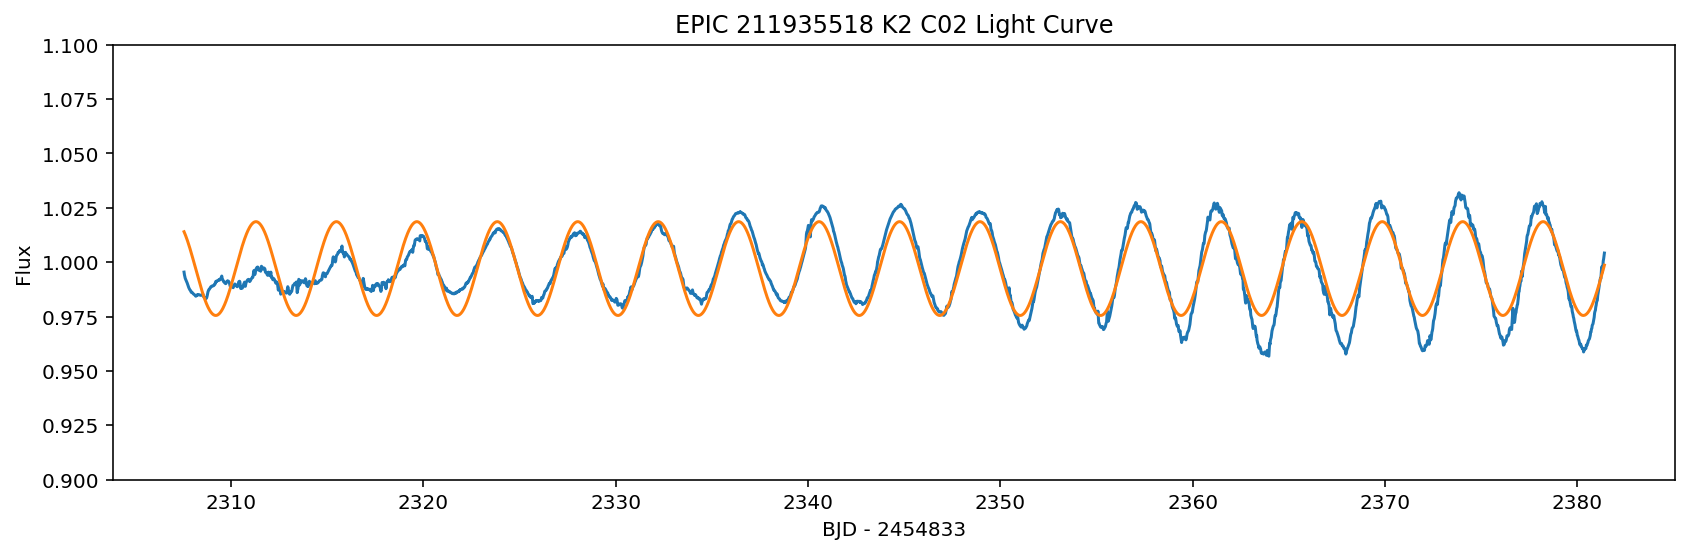

In [26]:
plt.figure(figsize=(14, 4))

plt.plot(x, y)
plt.plot(x, yfit)

plt.ylim(0.90, 1.10)
plt.title("EPIC {} K2 C02 Light Curve".format(211935518))
plt.xlabel('BJD - 2454833')
plt.ylabel('Flux');

In [27]:
from sklearn import cross_validation

/Users/obsidian/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
def lin_regress(A, y, yerr):
    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))
    return mean_w

In [29]:
polys = np.arange(1, 15)
net_scores = np.zeros(len(polys))
n_folds = 10

In [30]:
j = 0
for n_poly in polys:
    print(j)
    X = np.concatenate((np.expand_dims(cos_vector, 1),
                        np.expand_dims(sin_vector, 1),
                        np.vander(x, n_poly)), axis=1)
    n, n_dim = X.shape
    scores_test = np.zeros(n_folds)

    kf = cross_validation.KFold(n, n_folds=n_folds)
    i = 0
    for train_index, test_index in kf:
        #print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_err, y_test_err = yerr[train_index], yerr[test_index]
        w_train = lin_regress(X_train, y_train, y_train_err)
        y_test_fit = np.matmul(w_train, X_test.T)
        resid = np.sqrt(np.sum(((y_test-y_test_fit)/y_test_err)**2))
        scores_test[i] = resid
        i += 1
    net_scores[j] = np.mean(scores_test)
    j += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13


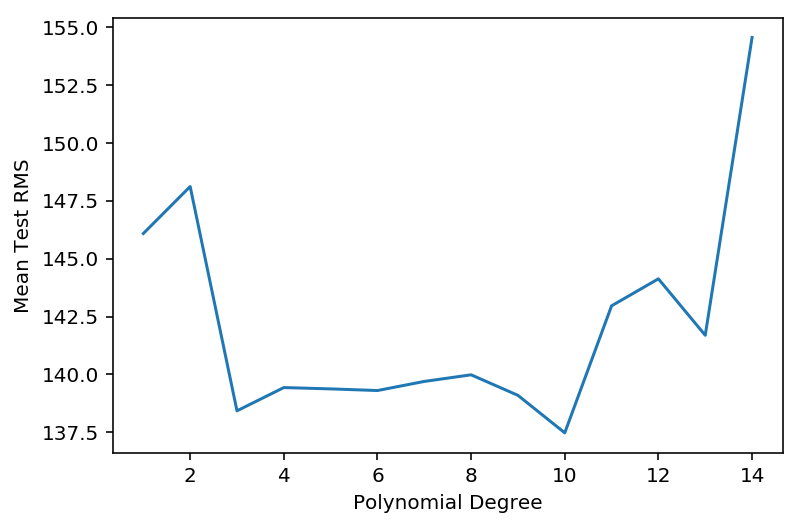

In [31]:
plt.plot(polys, net_scores)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Test RMS')

## Determine the amplitudes

In [32]:
opt_poly = polys[np.argmin(net_scores)]

In [33]:
A = np.concatenate((np.expand_dims(cos_vector, 1),
                    np.expand_dims(sin_vector, 1),
                    np.vander(x, opt_poly)), axis=1)

In [34]:
ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

In [35]:
#sns.heatmap(np.log10(sigma_w), annot=True)

In [36]:
mean_w

array([ -2.13189795e-02,   2.35832496e-03,   2.78155176e-29,
         5.06245739e-24,  -2.41908207e-20,   8.15489560e-17,
        -5.17742718e-13,   1.42414493e-09,  -6.52452917e-07,
        -5.70677161e-04,  -4.29742638e+00,   6.46244392e+03])

In [37]:
n_dim, = mean_w.shape

The first two are A and B.

In [38]:
np.sqrt(mean_w[0]**2 + mean_w[1]**2)

0.021449022927032498

In [39]:
yfit = np.matmul(mean_w, A.T)

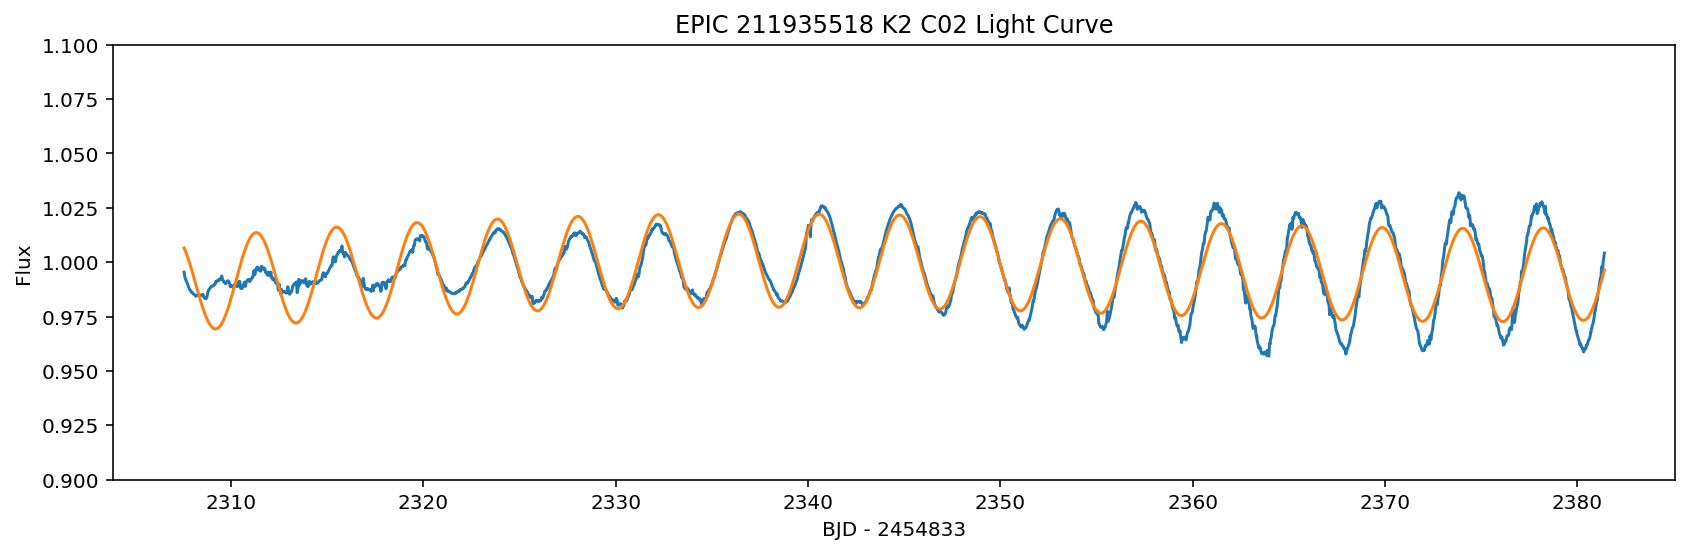

In [40]:
plt.figure(figsize=(14, 4))

plt.plot(x, y)
plt.plot(x, yfit)

plt.ylim(0.90, 1.10)
plt.title("EPIC {} K2 C02 Light Curve".format(211935518))
plt.xlabel('BJD - 2454833')
plt.ylabel('Flux');

That's just for *one* period.  But we have many from the multiterm fit!  Let's use that information.

## Fit number of Fourier components.

$\hat y = c_0 + c_1 \cdot x + c_2 \cdot \sin{\frac{2\pi x}{P}} + c_3 \cdot \cos{\frac{2\pi x}{P}} $  
becomes:

$\hat y = c_0 + c_1 \cdot x +  \dots + \sum_{j=1}^{N_j} a_j \cdot \sin{\frac{2\pi x}{P/j}} + b_j \cdot \cos{\frac{2\pi x}{P/j}} $

$\hat y = \sum_{i=0}^{N_i} c_i \cdot x^i + \sum_{j=1}^{N_j} a_j \cdot \sin{\frac{2\pi j x}{P}} + b_j \cdot \cos{\frac{2\pi j x}{P}} $

We have many coefficients: $c_i, a_j, b_j$

In [41]:
from gatspy.periodic import LombScargle, LombScargleFast

In [42]:
dy = y*0.0+0.0003

In [43]:
N_j = 4

In [44]:
sin_vectors = np.array([np.sin(2.0*np.pi*j*x/P_fit) for j in range(1, N_j+1)])
cos_vectors = np.array([np.cos(2.0*np.pi*j*x/P_fit) for j in range(1, N_j+1)])

# Multiperiod beat frequency

In [45]:
periods, P_M, P_LS

(array([ 3.34711071,  3.34727808,  3.34744546, ...,  5.02033132,
         5.02049869,  5.02066607]),
 array([ 0.00309334,  0.00310564,  0.00311796, ...,  0.00349598,
         0.00349067,  0.00348539]),
 array([ 0.0029841 ,  0.00299594,  0.00300779, ...,  0.00335201,
         0.00334708,  0.00334217]))

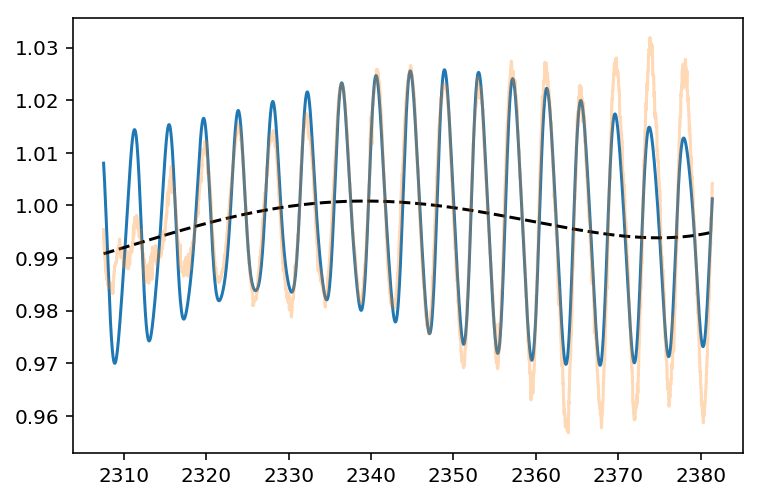

In [167]:
#P_fits = [4.183,  3.932626, 2.05549555]
dP=-0.05
P_fits = [4.1834699581569312,  3.932626, 2.05549555]

sin_vectors = np.array([np.sin(2.0*np.pi*x/P_fit) for P_fit in P_fits])
cos_vectors = np.array([np.cos(2.0*np.pi*x/P_fit) for P_fit in P_fits])

#sin_vectors = np.array([np.sin(2.0*np.pi*j*x/P_fit) for j in range(1, N_j+1)])
#cos_vectors = np.array([np.cos(2.0*np.pi*j*x/P_fit) for j in range(1, N_j+1)])

n_poly = 2
A = np.concatenate((cos_vectors.T,
                    sin_vectors.T,
                    np.vander(x, 10)), axis=1)

ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)
yfit_smooth = np.matmul(mean_w[-opt_poly:], A[:, -opt_poly:].T)

plt.plot(x, yfit)
plt.plot(x, yfit_smooth, 'k--')
plt.step(x, y, alpha=0.3)

In [182]:
from scipy.signal import savgol_filter

In [185]:
y.shape

(3401,)

In [187]:
3401 * 29.54 /(4.183*24*60.0)

16.67887547480543

In [204]:
y_sm = savgol_filter(y, 17, 3)

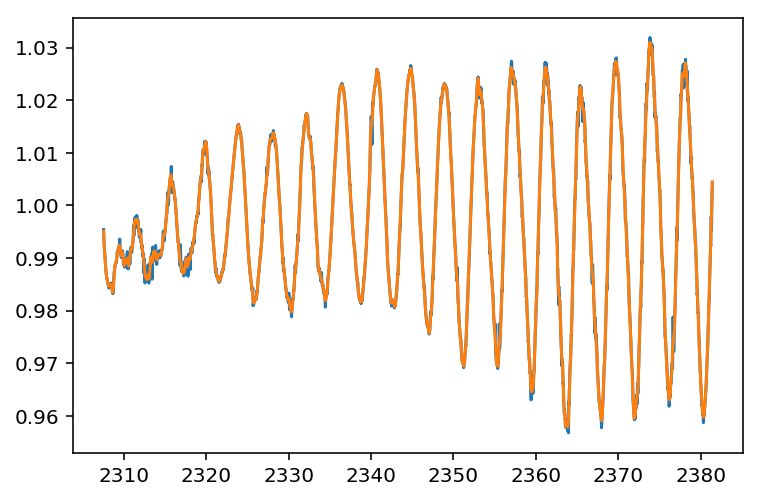

In [205]:
plt.plot(x, y)
plt.plot(x, y_sm)

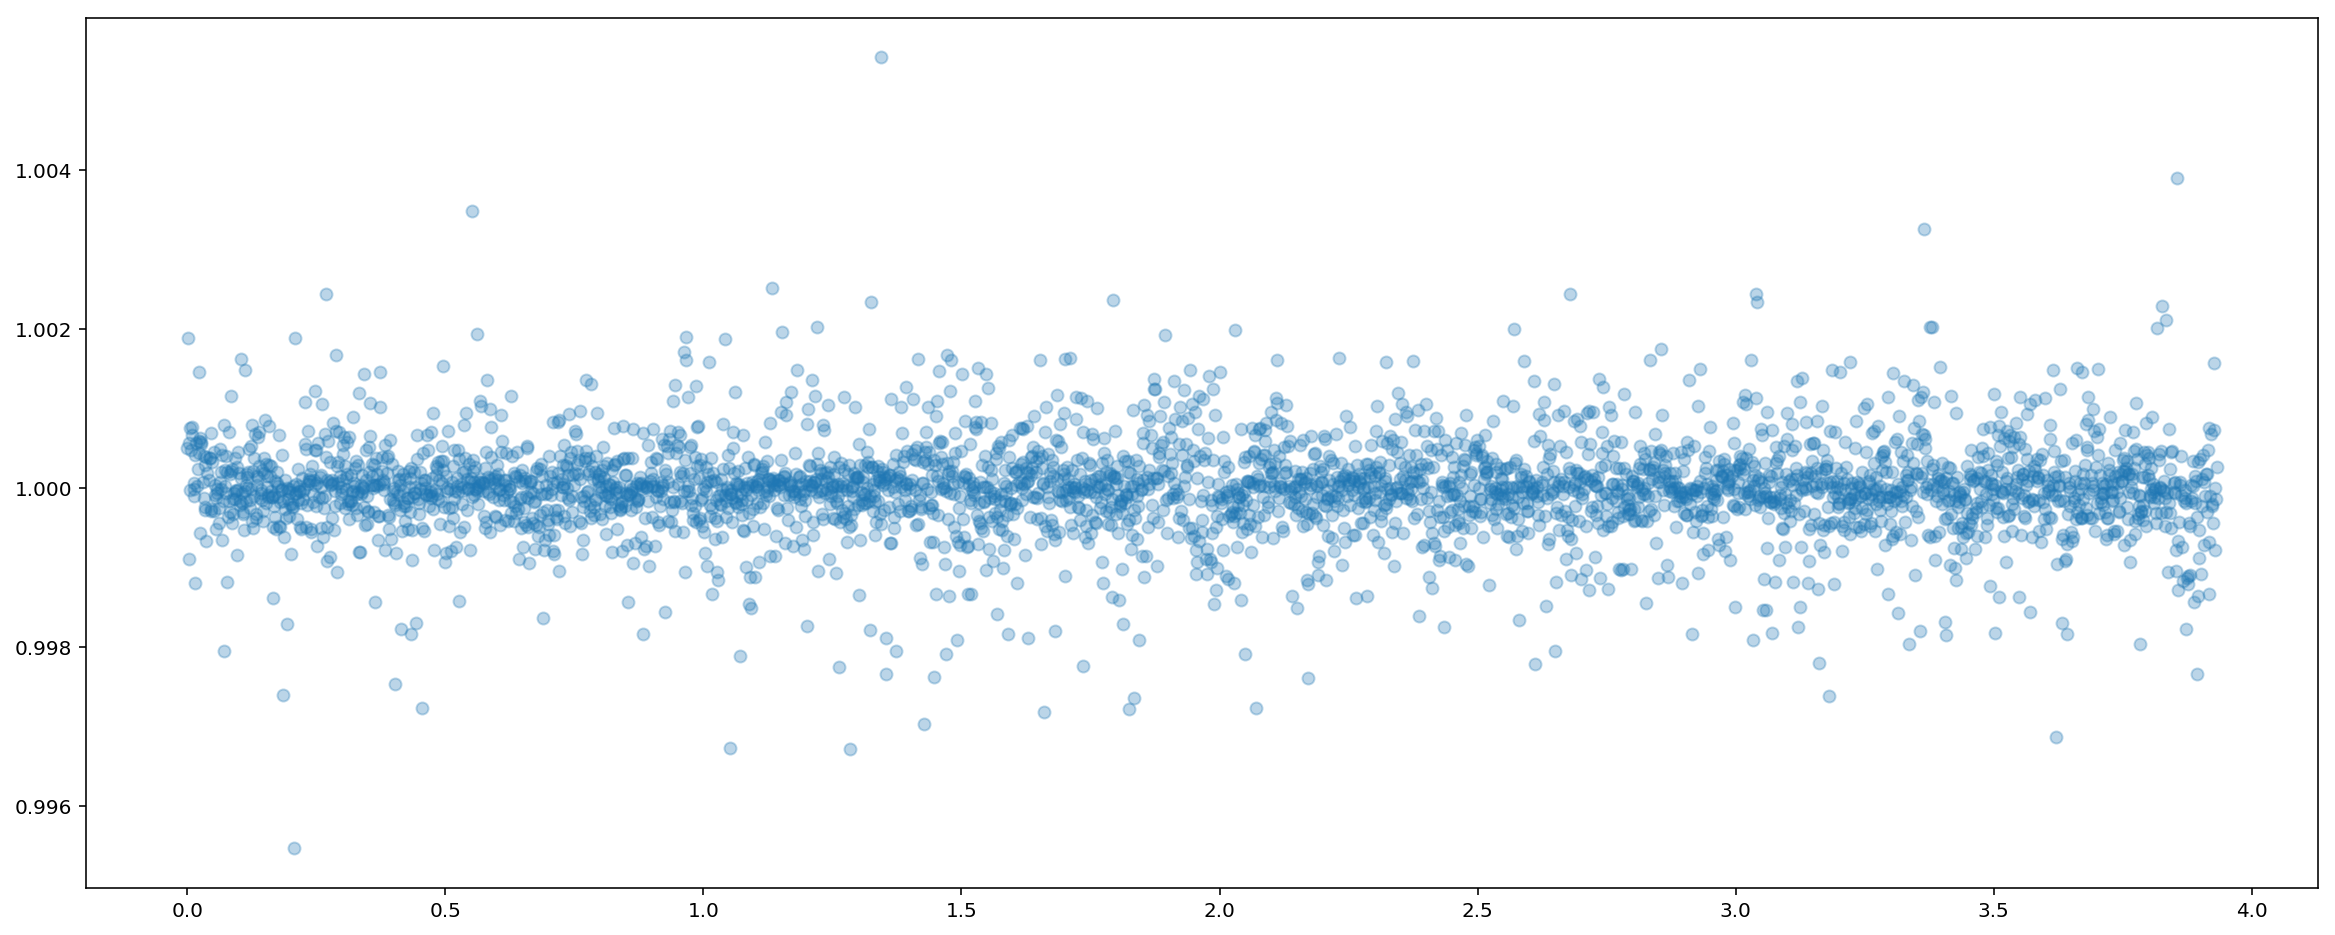

In [210]:
plt.figure(figsize=(20, 8))
plt.plot(phased, y/y_sm, 'o', alpha=0.3)

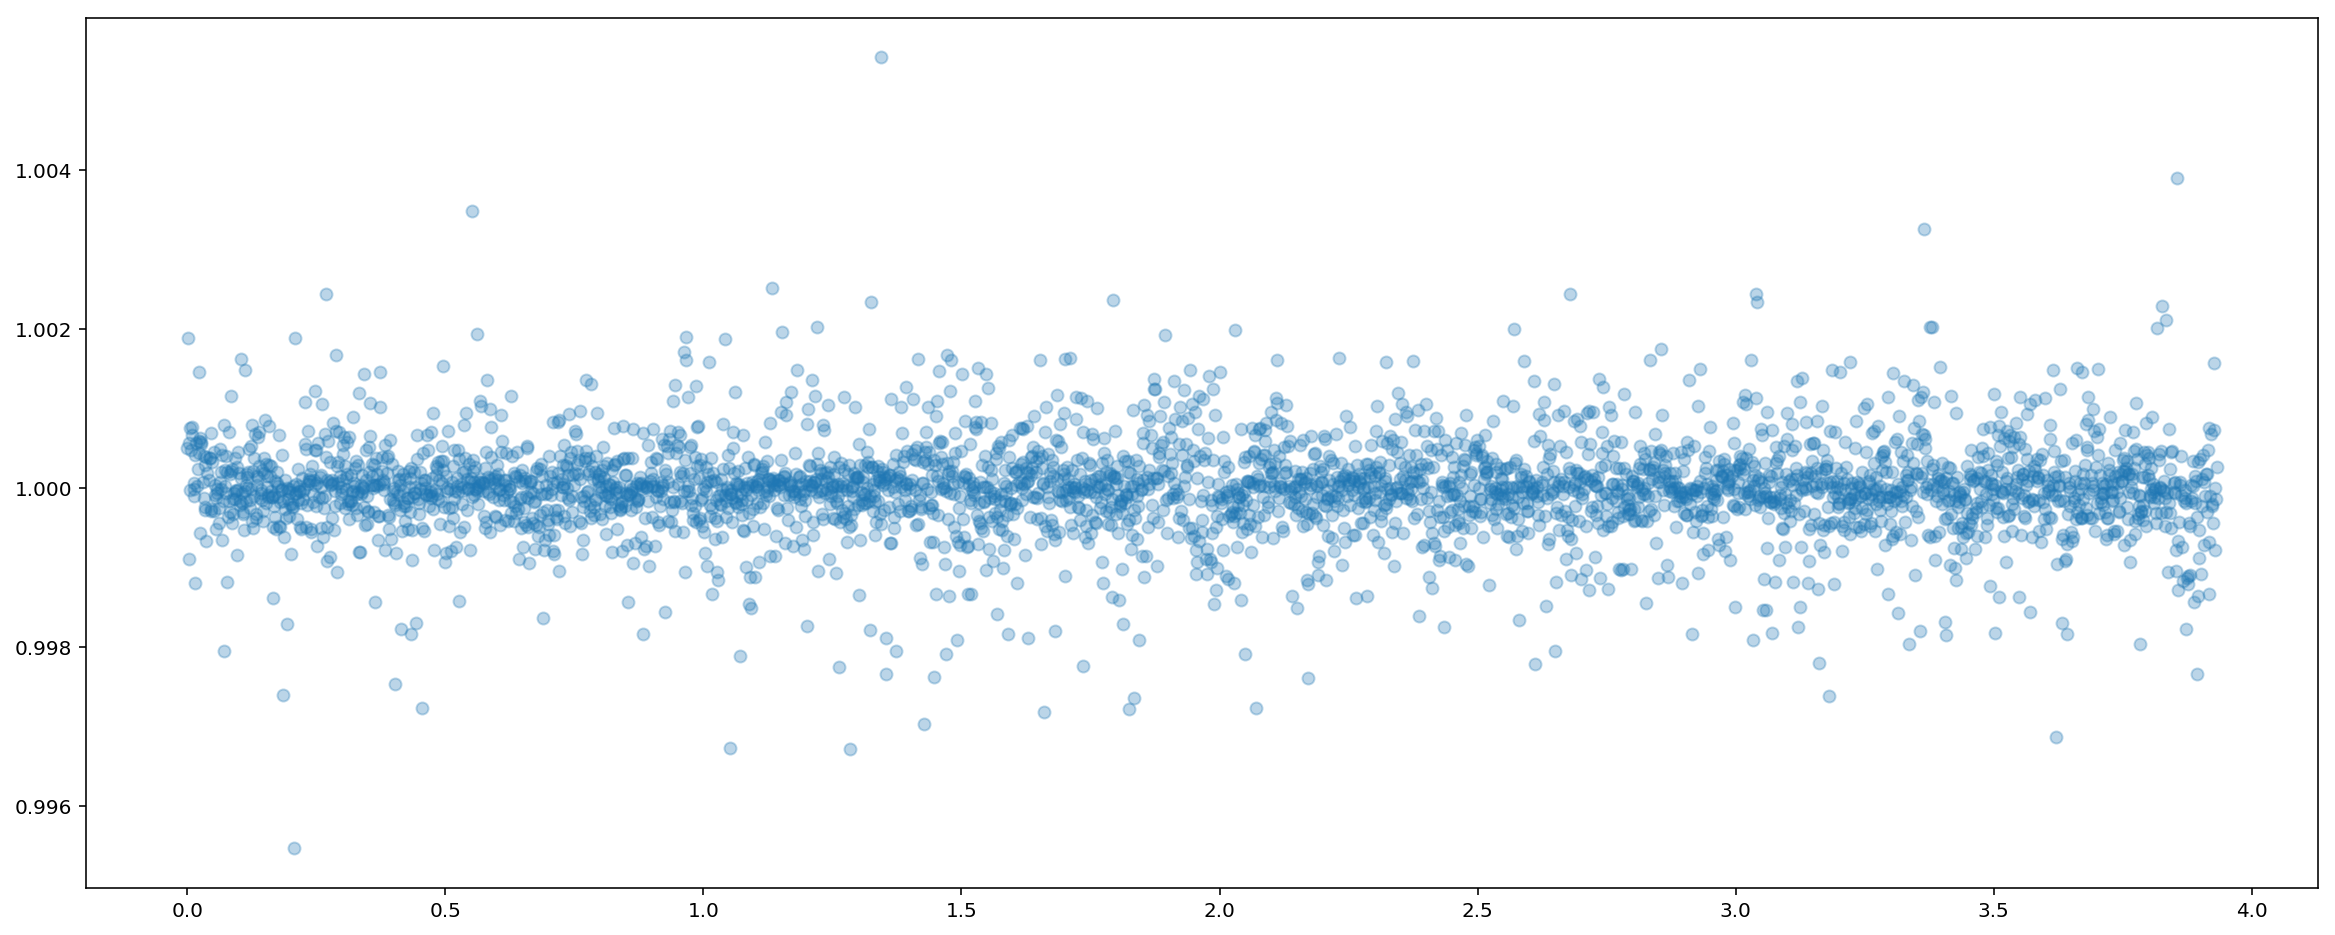

In [209]:
plt.figure(figsize=(20, 8))
plt.plot(phased, y/y_sm, 'o', alpha=0.3)

In [212]:
pass_num, phase = np.divmod(x, 3.932626)

In [213]:
pass_0 = pass_num -pass_num[0]

In [214]:
pass_0

array([  0.,   0.,   0., ...,  19.,  19.,  19.])

In [241]:
%matplotlib notebook

In [252]:
from scipy.signal import medfilt

In [259]:
medfilt(y, 11)

array([ 0.99169671,  0.99169671,  0.99169671, ...,  0.99733977,
        0.99733977,  0.99536637])

In [260]:
x

array([ 2307.5506376 ,  2307.5710697 ,  2307.5915019 , ...,  2381.37058619,
        2381.39101797,  2381.41144995])

In [258]:
plt.plot(x, medfilt(y, 11), '.')

<IPython.core.display.Javascript object>


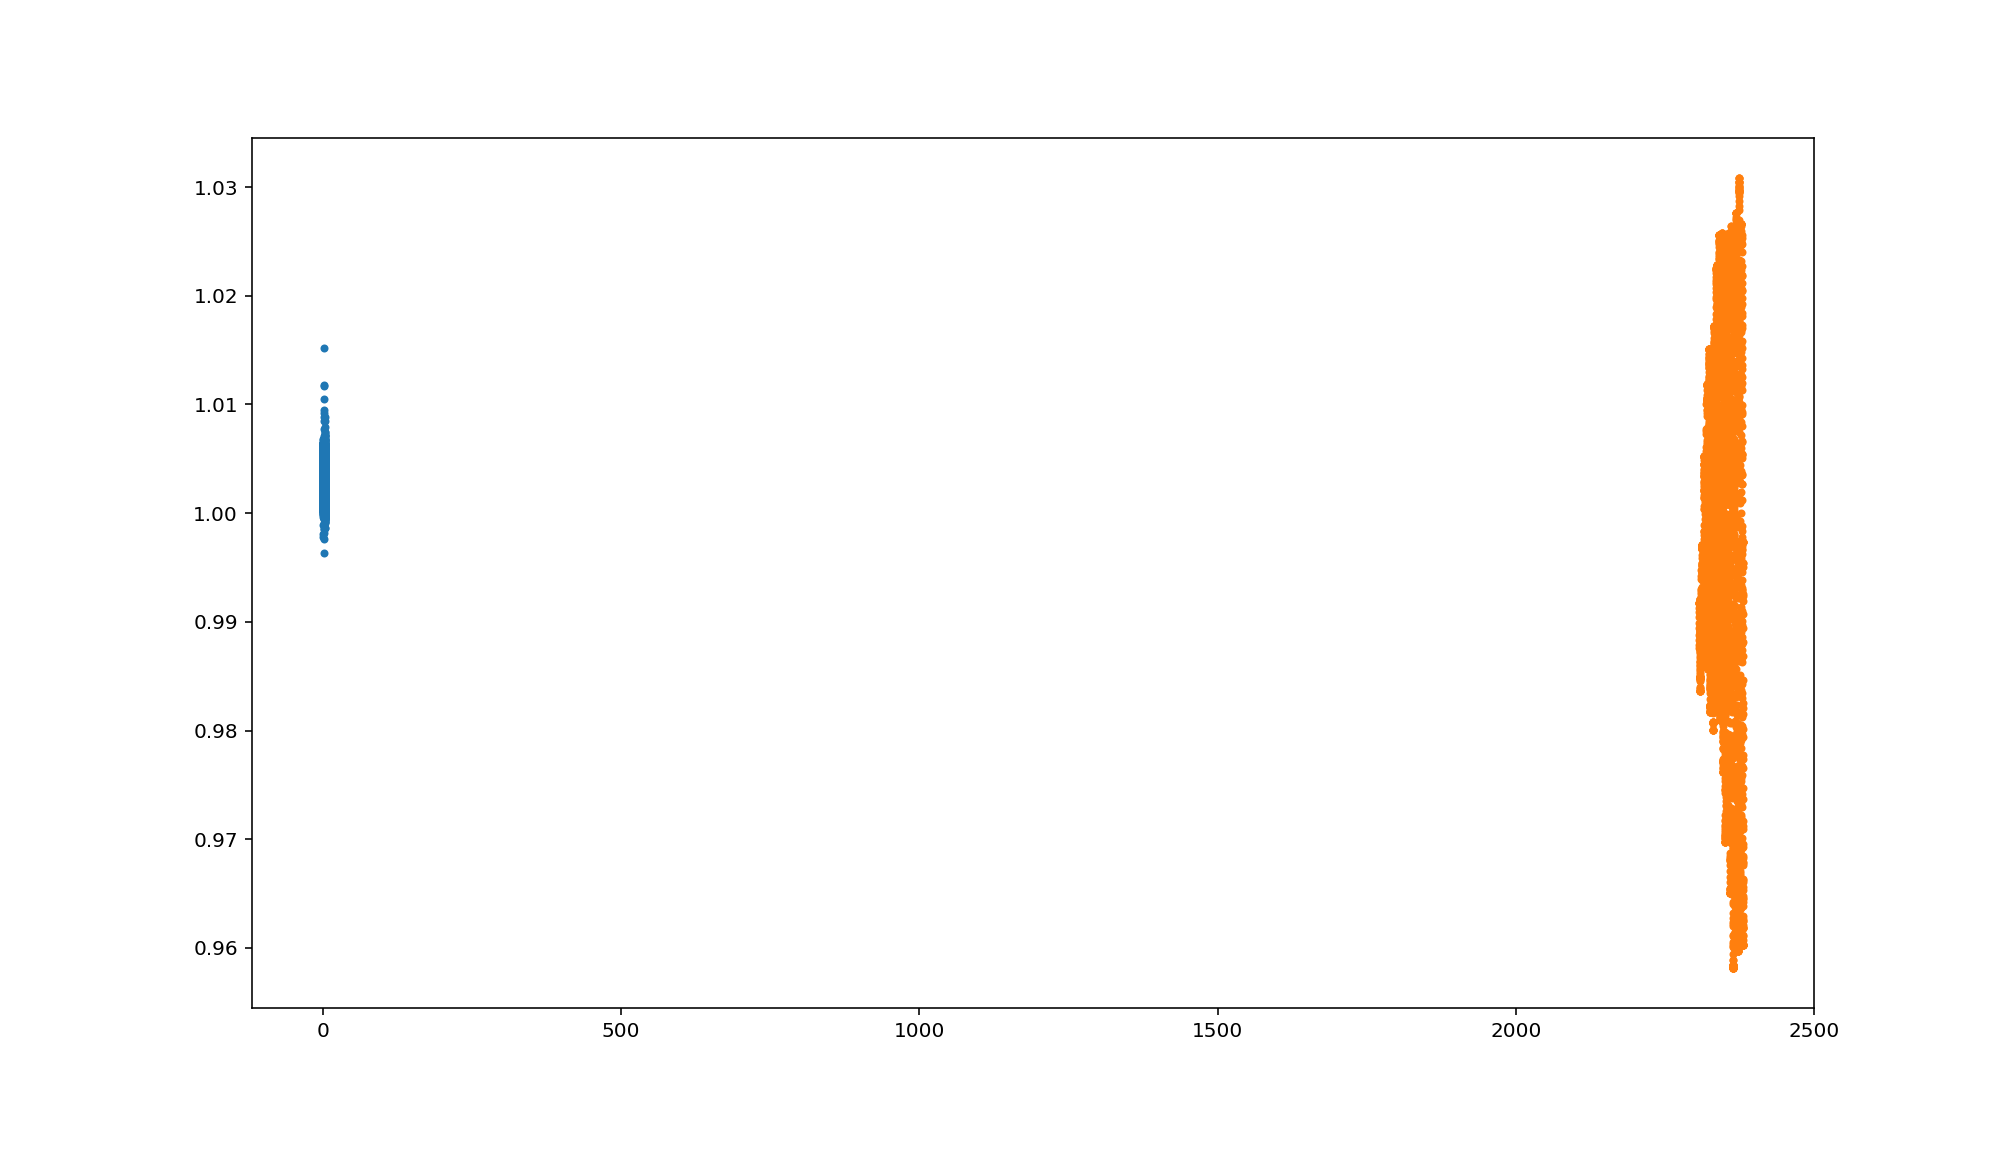

In [257]:
plt.figure(figsize=(14,8))
plt.plot(phase, y/medfilt(y, 11) +pass_0/3000.0, '.')

Kepler's Law:  
Assuming ~ 1 M_sun

$p^2 \propto a^3$

In [1]:
(3.932626/365.25)**(2/3)

0.04875976618161497

AU

In [2]:
0.048759 * 215 #AU/r_sun

10.483184999999999

10 solar radii orbit-- wow!

What is the fraction of orbit subtended by a 0.5 R_sun radius companion?

In [7]:
circum = 2.0*np.pi * 10.48

In [8]:
frac_subtend = 0.5 / circum

In [9]:
frac_subtend

0.00759327018568203

0.1% of the orbit is subtended by the companion, assuming a 0.5 Rsun.

In [10]:
0.00759*3.93*24*60.0

42.953328000000006

The "eclipse" floor would only last 42 min, if the main star were a point source.  

In [193]:
phased = np.mod(x, 3.932626)

In [179]:
resid = y - yfit

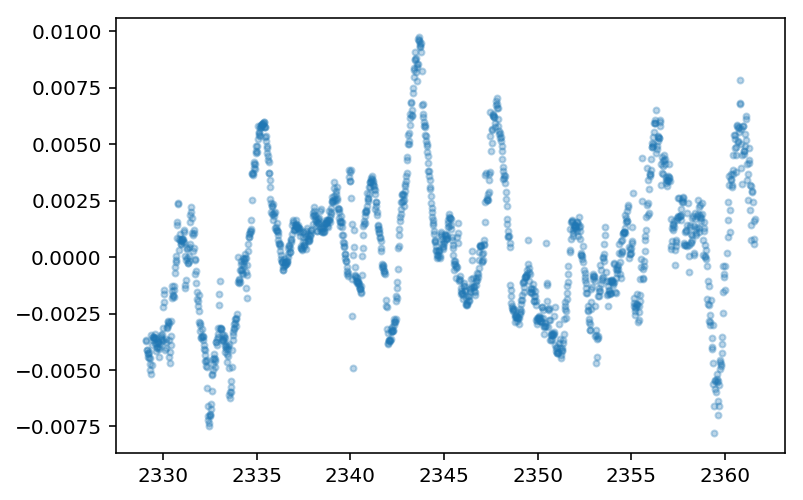

In [180]:
plt.plot(x[1000:2500], resid[1000:2500], '.', alpha=0.3)

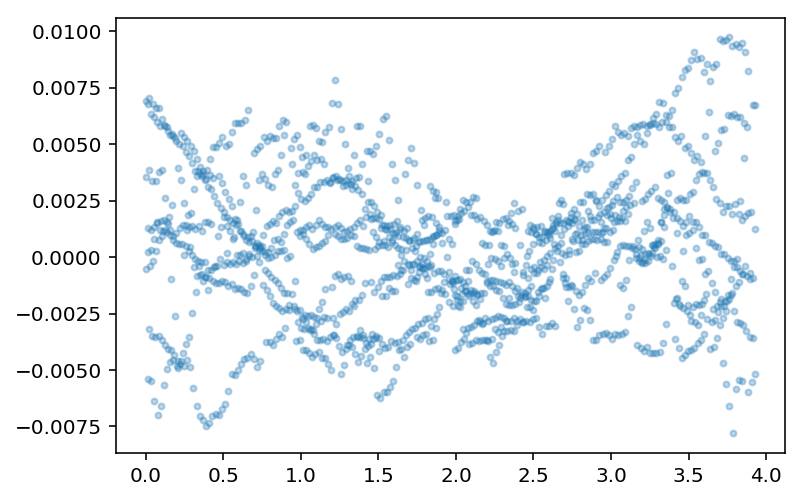

In [181]:
plt.plot(phased, resid[1000:2500], '.', alpha=0.3)

Residual of the time series.

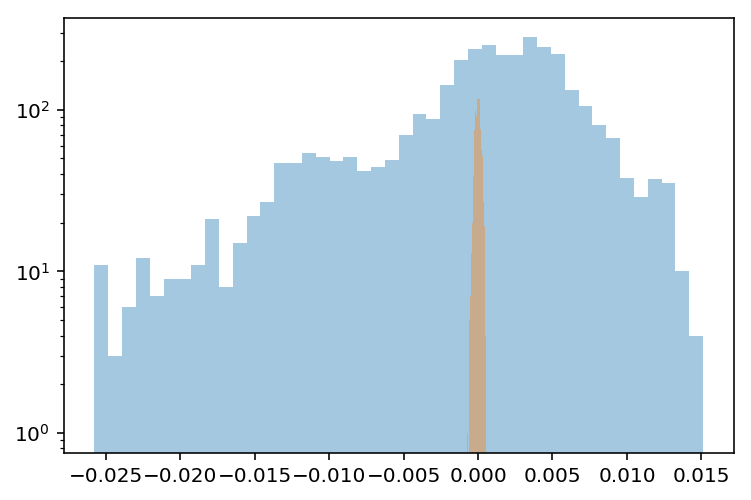

In [146]:
sns.distplot(resid, kde=False)
sns.distplot(np.random.normal(0, 0.0002, 1300), kde=False)
plt.yscale('log')

Seems like maybe an excess of high values, which makes sense-- we cannot capture the high frequency peaks.

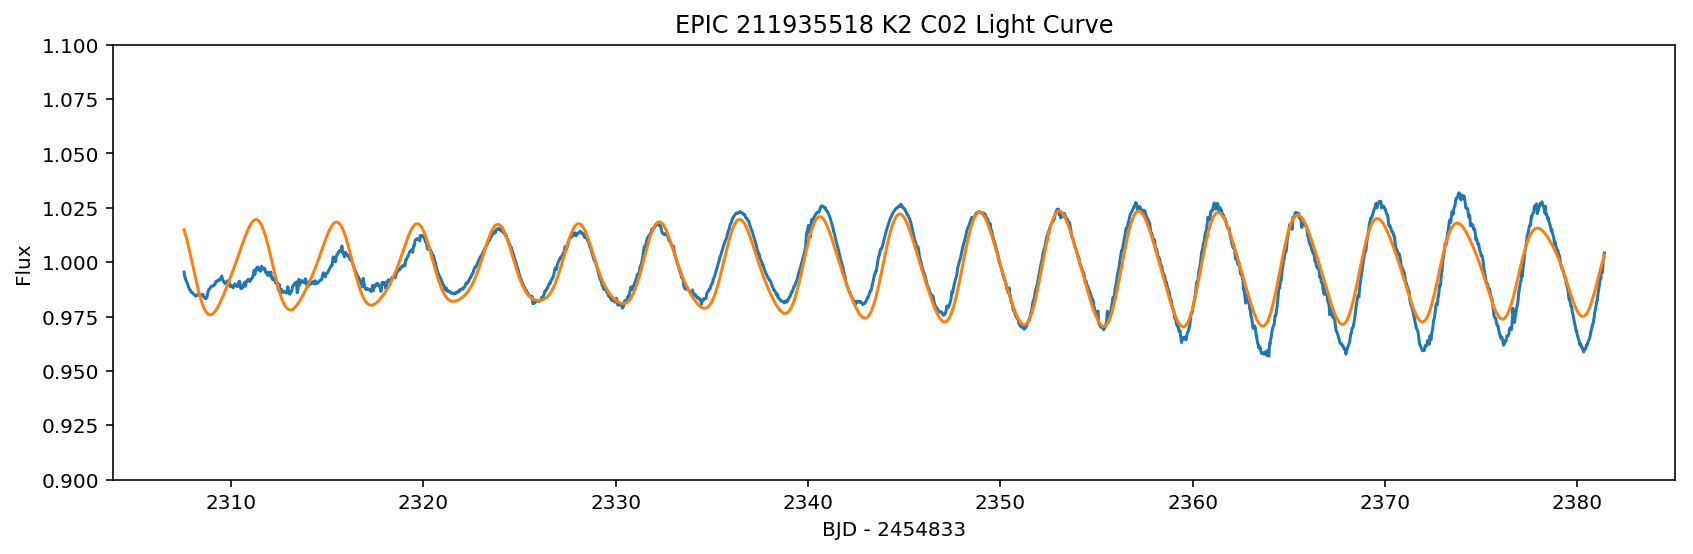

In [147]:
plt.figure(figsize=(14, 4))
plt.plot(x, y)
plt.plot(x, yfit)
plt.ylim(0.90, 1.10)
plt.title("EPIC {} K2 C02 Light Curve".format(211935518))
plt.xlabel('BJD - 2454833')
plt.ylabel('Flux');

In [148]:
this_cand = epic_id

ii = k2_c2.index[k2_c2.EPIC_ID == this_cand].values[0]

plt.figure(figsize=(14, 4))
file = k2_c2.fname[ii]
raw_lc = pd.read_csv(file, index_col=False)

#plt.plot(raw_lc['BJD - 2454833'], raw_lc[' Corrected Flux'])

plt.plot(x, y/yfit_smooth)
plt.plot(x, yfit/yfit_smooth)

plt.ylim(0.995, 1.005)
#plt.ylim(0.90, 1.10)
plt.title("EPIC {} K2 C02 Light Curve".format(k2_c2.EPIC_ID[ii]))
plt.xlabel('BJD - 2454833')
plt.ylabel('Flux');

NameError: name 'epic_id' is not defined

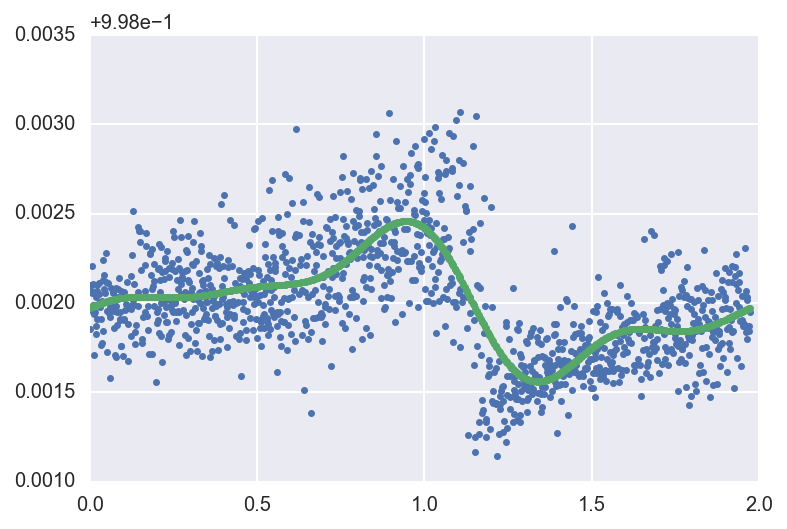

In [110]:
plt.plot(np.mod(x,P_fit), y/yfit_smooth, '.')
plt.plot(np.mod(x,P_fit), yfit/yfit_smooth, '.')